In [12]:
# load nyc_motor_vehicle_collisions dataset
import pandas as pd
df = pd.read_csv('../data/interim/crashes.csv')

# change number_of_persons_injured and number_of_persons_killed to injured, killed respectively
df = df.rename(columns={'number_of_persons_injured': 'injured', 'number_of_persons_killed': 'killed'})
df.head()

,crash_date,crash_time,latitude,longitude,injured,killed
0,2023-11-01,1:29,40.621790,-73.970024,1.0,0.0
1,2021-09-11,9:35,40.667202,-73.866500,0.0,0.0
2,2021-12-14,8:13,40.683304,-73.917274,0.0,0.0
3,2021-12-14,17:05,40.709183,-73.956825,0.0,0.0
4,2021-12-14,8:17,40.868160,-73.831480,2.0,0.0


In [13]:
import geopandas as gpd

# Load
neighborhoods = gpd.read_file('../data/external/neighborhoods.geojson')

# Inspect
print(neighborhoods.head())
print(neighborhoods.crs)  # check the coordinate system
print(len(neighborhoods))  # how many neighborhoods?


   OBJECTID  BoroCode  BoroName CountyFIPS NTA2020             NTAName  \
0         1         3  Brooklyn        047  BK0101          Greenpoint   
1         2         3  Brooklyn        047  BK0102        Williamsburg   
2         3         3  Brooklyn        047  BK0103  South Williamsburg   
3         4         3  Brooklyn        047  BK0104   East Williamsburg   
4         5         3  Brooklyn        047  BK0201    Brooklyn Heights   

   NTAAbbrev NTAType CDTA2020  \
0      Grnpt       0     BK01   
1   Wllmsbrg       0     BK01   
2  SWllmsbrg       0     BK01   
3  EWllmsbrg       0     BK01   
4      BkHts       0     BK02   

                                            CDTAName   Shape__Area  \
0     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  3.532181e+07   
1     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  2.885431e+07   
2     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  1.520896e+07   
3     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)  5.226741e+07   
4  BK0

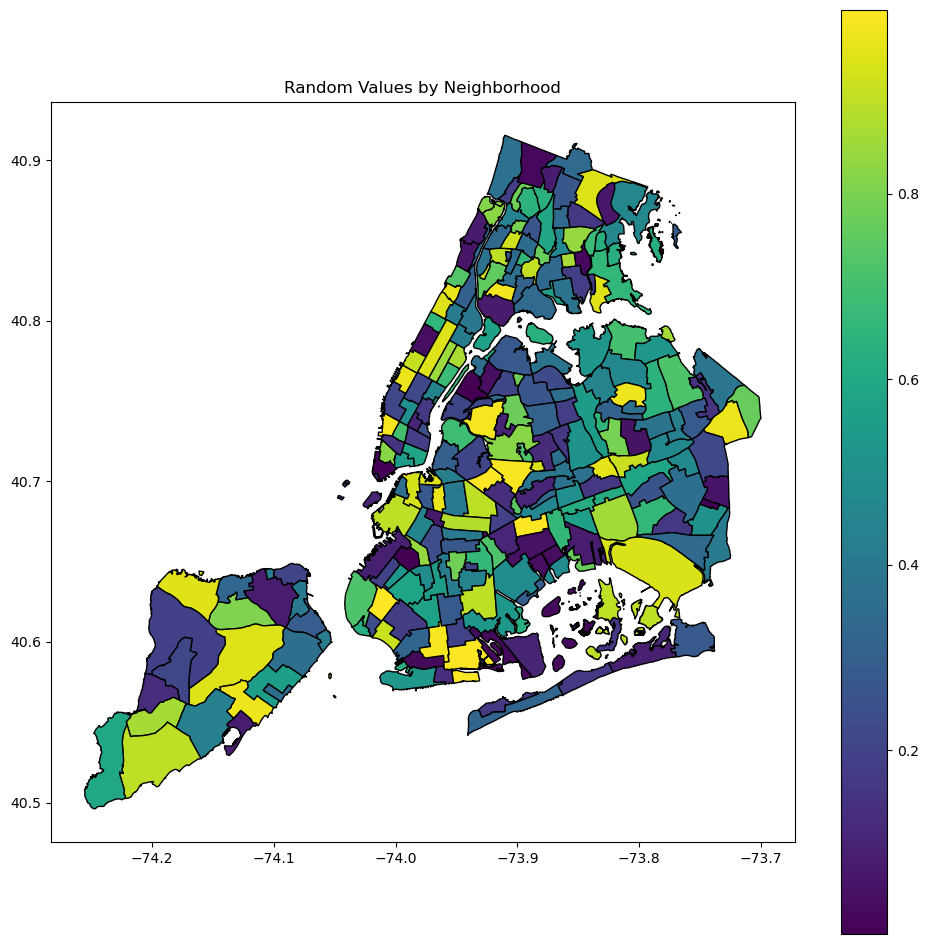

In [14]:
import numpy as np

# Assume you already have neighborhoods loaded
neighborhoods['random_value'] = np.random.rand(len(neighborhoods))

import matplotlib.pyplot as plt

neighborhoods.plot(
    column='random_value',
    cmap='viridis',
    legend=True,
    figsize=(12, 12),
    edgecolor='black'
)
plt.title('Random Values by Neighborhood')
plt.show()


In [15]:
import plotly.express as px

fig = px.choropleth_mapbox(
    neighborhoods,
    geojson=neighborhoods.geometry.__geo_interface__,
    locations=neighborhoods.index,
    color='random_value',
    mapbox_style='carto-positron',
    center={"lat": 40.7128, "lon": -74.0060},
    zoom=9,
    opacity=0.7
)

# SAVE TO FILE INSTEAD OF SHOWING
fig.write_html("test_map.html")


/var/folders/_6/p9nq2tdd6418xp1vt5dxwqhm0000gn/T/ipykernel_17330/4067711755.py:3: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [16]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load crashes.csv
crashes = pd.read_csv('../data/interim/crashes.csv')  # or wherever you saved

# Create points
crashes_gdf = gpd.GeoDataFrame(
    crashes,
    geometry=gpd.points_from_xy(crashes.longitude, crashes.latitude),
    crs='EPSG:4326'
)

In [17]:
# Load neighborhoods if not already
neighborhoods = gpd.read_file('../data/external/neighborhoods.geojson')

# Spatial join: find which neighborhood each crash is in
crashes_with_neighborhood = gpd.sjoin(crashes_gdf, neighborhoods, how='left', predicate='within')

# Now each crash has a 'NTAName' column (neighborhood name) attached

In [20]:
# Group by neighborhood
agg = crashes_with_neighborhood.groupby('NTAName').agg(
    total_crashes=('crash_date', 'count'),  # just counting rows
    total_injured=('number_of_persons_injured', 'sum'),
    total_killed=('number_of_persons_killed', 'sum')
).reset_index()

In [21]:
# Merge
neighborhoods = neighborhoods.merge(agg, on='NTAName', how='left')

# Fill any missing (no crashes) with 0
neighborhoods[['total_crashes', 'total_injured', 'total_killed']] = neighborhoods[['total_crashes', 'total_injured', 'total_killed']].fillna(0)

In [23]:
import plotly.express as px

def plot_choropleth(gdf, color_col, out_file):
    fig = px.choropleth_mapbox(
        gdf,
        geojson=gdf.geometry.__geo_interface__,
        locations=gdf.index,
        color=color_col,
        mapbox_style='carto-positron',
        center={"lat": 40.7128, "lon": -74.0060},
        zoom=9,
        opacity=0.7,
        hover_name='NTAName',
        color_continuous_scale='OrRd'
    )
    fig.write_html(out_file)

# Crashes map
plot_choropleth(neighborhoods, 'total_crashes', '../reports/figures/total_crashes_map.html')

# Injuries map
plot_choropleth(neighborhoods, 'total_injured', '../reports/figures/total_injured_map.html')

# Killed map
plot_choropleth(neighborhoods, 'total_killed', '../reports/figures/total_killed_map.html')


/var/folders/_6/p9nq2tdd6418xp1vt5dxwqhm0000gn/T/ipykernel_17330/4257802173.py:4: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/_6/p9nq2tdd6418xp1vt5dxwqhm0000gn/T/ipykernel_17330/4257802173.py:4: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/_6/p9nq2tdd6418xp1vt5dxwqhm0000gn/T/ipykernel_17330/4257802173.py:4: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [27]:
# load processed/crashes.csv
crashes = pd.read_csv('../data/processed/crashes.csv')

In [28]:
# count number of unique neighborhoods
len(crashes['neighborhood'].unique())

238

In [29]:
# count number of rows in crashes
crashes.shape

(1773561, 7)

Default Data

In [9]:
# load interim/crashes.csv
import pandas as pd
crashes = pd.read_csv('../data/raw/nyc_motor_vehicle_collisions.csv')

/var/folders/_6/p9nq2tdd6418xp1vt5dxwqhm0000gn/T/ipykernel_24000/2843512576.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  crashes = pd.read_csv('../data/raw/nyc_motor_vehicle_collisions.csv')


In [11]:
print(f"Injured: {crashes['number_of_persons_injured'].sum():,}")
print(f"Killed: {crashes['number_of_persons_killed'].sum():,}")
print(f"Total Crashes: {crashes.shape[0]:,}")


Injured: 699,348.0
Killed: 3,367.0
Total Crashes: 2,171,175


In [13]:
# find start and end dates
print("Date Range:", crashes['crash_date'].min(), "to", crashes['crash_date'].max())

Date Range: 2012-07-01T00:00:00.000 to 2025-04-22T00:00:00.000


In [14]:
# load processed crashes
crashes = pd.read_csv('../data/processed/crashes.csv')


In [15]:
crashes.shape

(1773561, 7)